# Yinson Hydromover

### Initial setup

In [77]:
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
sys.path.append("../../")
from vessel_model_tuning_lib import ship_dimensions, maneuvering, resistance, seakeeping, vessel_model_common, actuators

plt.style.use('bmh')

## Vessel data input section
For transparency, all input data used to create the vessel model should be stated in this section. All data used to override default values should also be defined here.

In [78]:
'''
Required data
'''

ship_name = 'CStrider'
Lwl = 8.1 # Length in waterline
B = 3.04 # Beam in the water line (CC mellan propellrarna: 215cm + Bredd per skrov: 0.89)
volume_displacement = 3.3 # Mid load condition
T = 0.35 # Draft amidships
'''
Additional known data used in the modelling
'''

#Thruster data
max_forward_power = 6e3 # watt per thruster
max_backward_power = 3e3 # watt per thruster
max_rpm = 1700 # 
min_rpm = -1300 # Estimated to match rated max_backward_power =
propeller_diameter = 11.3*0.0254
propeller_pitch_ratio = 8.5 / 11.3 # 0.7522
longitudunal_placement_from_stern = 0.0 #m Guesstimate, exact value TBD


# Hull data
B_single_hull = 0.89
longitudonal_center_of_gravity = 4.0 # m from stern. Guesstimate, exact value TBD

#Resistance data
max_speed_knots = 6.5
cruising_speed_knots = 5.0


# Hydrostatics
GM_roll = 3.0 # Guesstimate, exact value TBD
GM_pitch = 9.0 # Guesstimate, exact value TBD

'''
Data estimated from tuning or model fitting (TODO)
'''
propeller_geometry = actuators.PropellerGeometry.WAGENINGEN_B4_70_PD08 # Selected due to closest pitch match
CD_lateral = 0.08 #Extra resistance due to viscous effects (such as submerged transom stern). Use kvlcc2 default
damping_ratio_heave = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_roll = 0.15 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_pitch = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response

### Define the physical constants to be used in the modelling, override defaults if necessary

In [79]:
physical_constants = vessel_model_common.physical_constants()

### Generate ship coefficients based on given main dimension using empirical formulat
If any coefficients are known, they can be overridden in the generated `ship_dimensions` object

In [80]:
# Create ship dim object for single hull of the catamaran.
single_hull_dim = ship_dimensions.ShipDimensions(Lwl, B_single_hull, T, volume_displacement/2)
single_hull_dim.calculate_shape_coefficients()
single_hull_dim.print()

ship_dim = ship_dimensions.ShipDimensions(Lwl, B, T, volume_displacement)
ship_dim.calculate_shape_coefficients()
ship_dim.S = 2*single_hull_dim.S
ship_dim.print()





Wetted surface:    9.3 m^2
Longitudonal center of gravity:    0.0 m
Longitudonal center of buoyancy:    0.0 m
Block coefficient: 0.6539
Prismatic coefficient: 0.7125
Mid section coefficient: 0.95
Water plane coefficient: 0.75
Wetted surface:    18.5 m^2
Longitudonal center of gravity:    0.0 m
Longitudonal center of buoyancy:    0.0 m
Block coefficient: 0.3829
Prismatic coefficient: 0.7125
Mid section coefficient: 0.95
Water plane coefficient: 0.75


## Propeller tuning

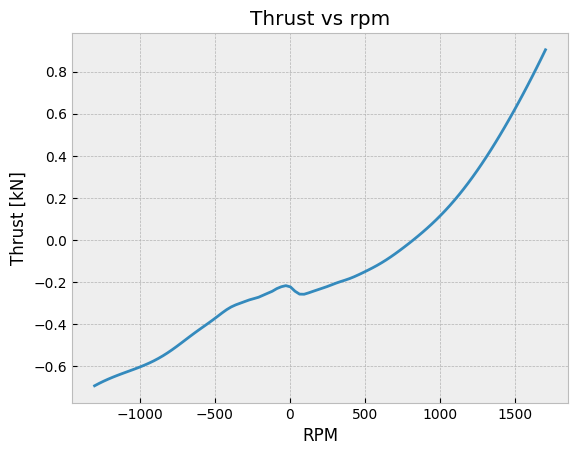

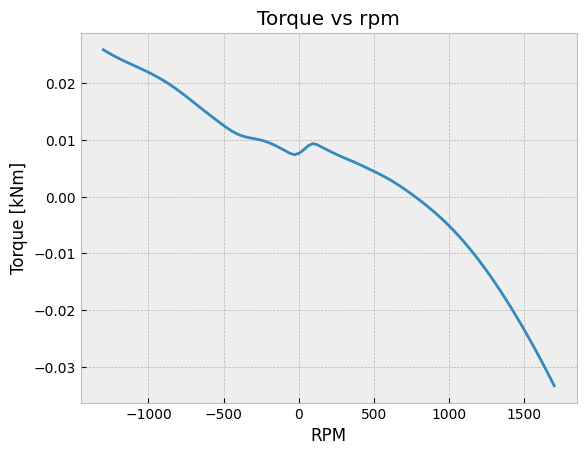

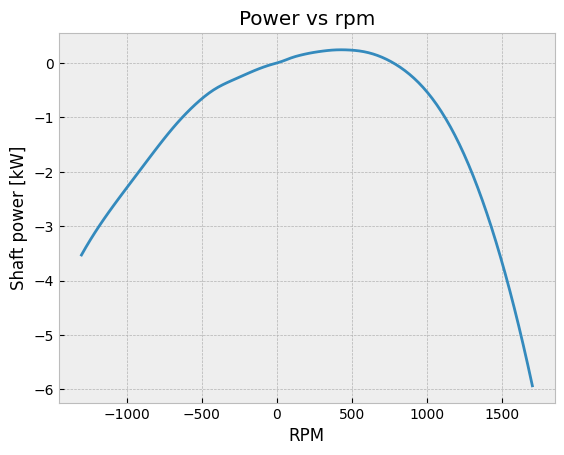

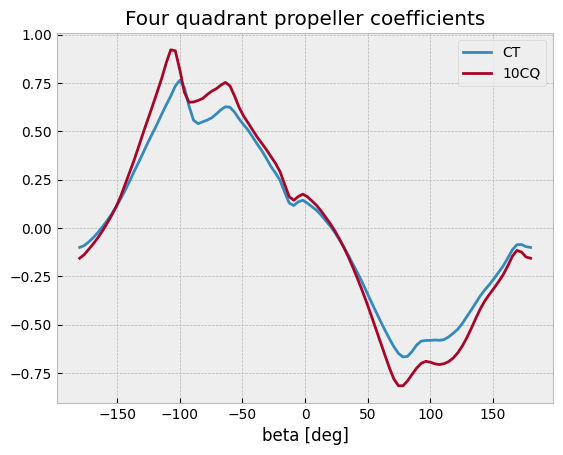

KT0 = 0.2603338160775637


In [81]:
pitch_scaling_factor = propeller_pitch_ratio / 1.0 # Linear scaling of thrust/torque coefficients based of ration between PD for propeller geometry and PD for actual propeller
prop = actuators.FourQuadrantPropeller(propeller_geometry, propeller_diameter, pitch_scaling_factor)

#Plot thrust
speed = vessel_model_common.knots_to_ms * max_speed_knots
rpm_list = np.linspace(min_rpm, max_rpm, 100)
thrust_ax, torque_ax, power_ax = prop.plot_thrust_torque_power_vs_rpm(rpm_list, speed)

#Plot four quadrant curves for propeller geometry
prop.four_quadrant_plot()
plt.show()

print(f"KT0 = {prop.get_KT0()}")


## Straight ahead resistance

### Estimate paramaters for straight ahead resistance

Shape factor, k =  0.0477


Text(0.5, 0, 'Speed [kn]')

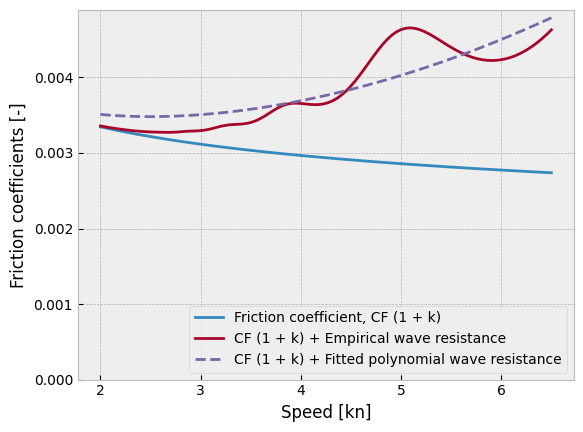

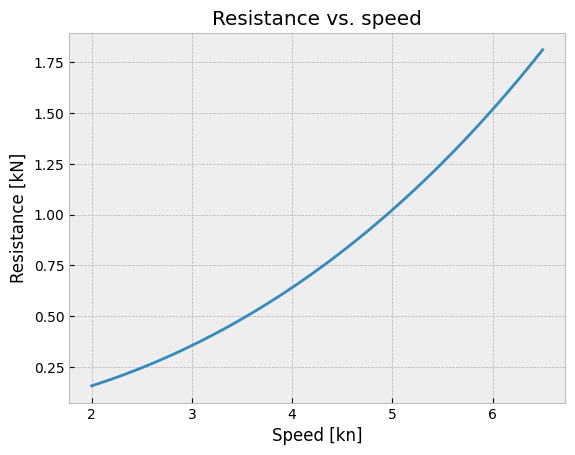

In [82]:
n = 100
U_res_knots = np.linspace(2, max_speed_knots, n)
U_res = U_res_knots * vessel_model_common.knots_to_ms

Fr = U_res / np.sqrt(single_hull_dim.L * physical_constants.g) #Froude number

k = resistance.marintek_shape_factor(single_hull_dim) #Empirical shape factor based on MARINTEK formula

print('Shape factor, k = ', np.round(k, 4))


CR = np.zeros(n)
CF = np.zeros(n)
for i in range(n):
    CR[i] = resistance.holtrop_wave_resistance(single_hull_dim, U_res[i], physical_constants.g, physical_constants.rho) # Resistance coeff due to wave generation (empirical based on Holtrop's method)
    CF[i] = resistance.CF_ITTC(single_hull_dim, U_res[i], physical_constants.nu) * (1 + k) # Resistance coeff due to friction (empirical based on ITTC friction line)
CT = CF + CR
    
CR_m, CR_p = resistance.fit_wave_polynomial(Fr, CR) # Fit resistance model to polynomial model to be used in the FMU
CR_model = resistance.CR_wave_polynomial(Fr, CR_m, CR_p)

#Plot resistance coefficients
plt.figure()
plt.plot(U_res_knots, CF, label='Friction coefficient, CF (1 + k)')
plt.plot(U_res_knots, CF + CR, label='CF (1 + k) + Empirical wave resistance')
plt.plot(U_res_knots, CF + CR_model, '--', label='CF (1 + k) + Fitted polynomial wave resistance')
plt.legend(loc=4)
plt.ylim(0.0, None)
plt.xlabel('Speed [kn]')
plt.ylabel('Friction coefficients [-]')

#Create resistance model (same as used in the FMU)
resistance_model = resistance.Resistance(ship_dim, physical_constants)
resistance_model.k          = k
resistance_model.CR_m       = CR_m
resistance_model.CR_p       = CR_p
resistance_model.CD_lateral = CD_lateral

res = np.zeros(n)
for i in range(n):
    res[i] = resistance_model.get_resistance(U_res[i])

#Plot resistance curve together with data points for model fitting (TODO : Add datapoints if available)
plt.figure()
plt.plot(U_res_knots, res/1e3)
plt.title('Resistance vs. speed')
plt.ylabel('Resistance [kN]')
plt.xlabel('Speed [kn]')

# ground_thruth_resistance = resistance_data_force
# plt.plot(resistance_data_speed_knots, ground_thruth_resistance/1e3, marker='x')
# plt.legend(['Resistance curve', 'Data points from Yinson'])


## Maneuvering model

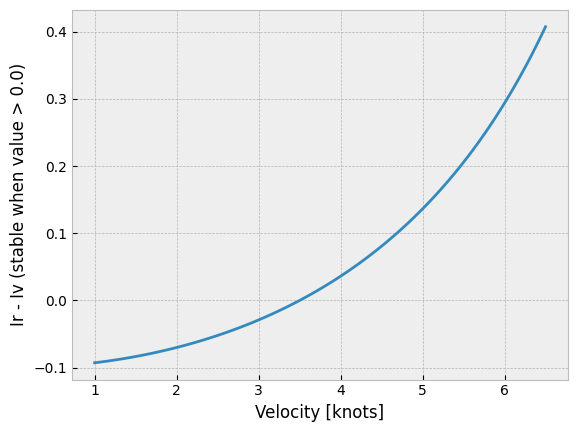

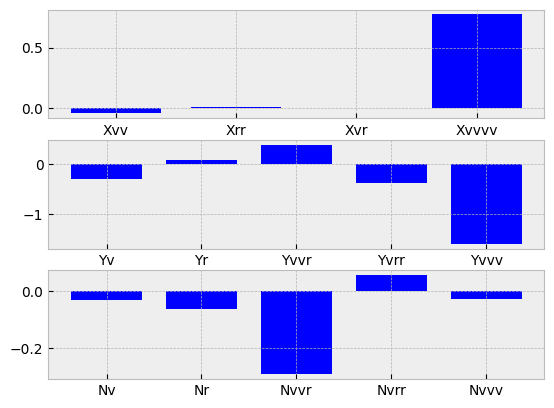

In [83]:
maneuvering_model = maneuvering.MMGModel(ship_dim, physical_constants)
U_stable = 3.5 * 0.5144444444 # Speed where the model is forced to be stable
maneuvering_model.stabilize_coefficients(U_stable, x_cp = 0.1)

#Check directional stability
U_man = np.linspace(1, max_speed_knots, n) * vessel_model_common.knots_to_ms

stability = np.zeros(n)
for i in range(n):
    stability[i] = maneuvering_model.check_linear_stability(U_man[i])
    
plt.figure()
plt.plot(U_man *vessel_model_common.ms_to_knots, stability)
plt.xlabel('Velocity [knots]')
plt.ylabel('Ir - Iv (stable when value > 0.0)')

#Visualize model parameters
maneuvering_model.plot_model_parameters()

# Seakeeping model

Heave: Natural period:  1.20s, damping ratio: 0.3
Roll: Natural period:  1.28s, damping ratio: 0.15
Pitch: Natural period:  1.73s, damping ratio: 0.3


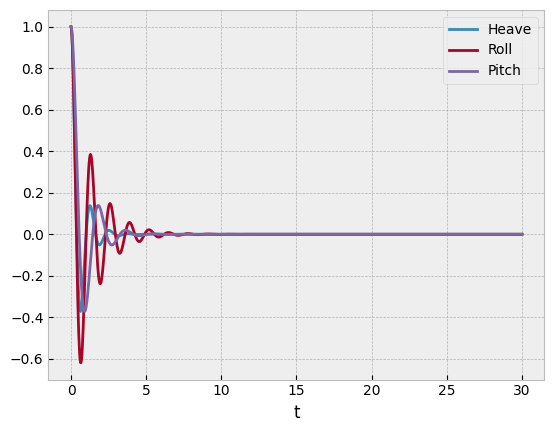

In [84]:
inertias = seakeeping.Inertias(ship_dim, physical_constants)#Set default values for inertias
inertias.set_horizontal_added_mass_from_maneuvering_model(maneuvering_model.added_mass)#Use values from maneuvering model in the horizontal dof's since these are avaiable

waterplane_area = ship_dim.C_water_plane*ship_dim.L*ship_dim.B
hydrostatics = seakeeping.Hydrostatics(GM_roll, GM_pitch, waterplane_area)

damping_ratios = [damping_ratio_heave, damping_ratio_roll, damping_ratio_pitch]

seakeeping_model = seakeeping.Seakeeping(ship_dim, physical_constants, hydrostatics, inertias, damping_ratios)

seakeeping_model.print_seakeeping_data()
seakeeping_model.plot_decay_response()



## Generate XML formatted FMU parameters that can be directly inserted into an OSP config

In [85]:
osp_param_gen = vessel_model_common.OSPParameterGen(ship_dim, physical_constants, maneuvering_model, seakeeping_model, resistance_model, prop)

#hull_maneuvering parameters
hull_maneuvering_params = osp_param_gen.generate_hull_maneuvering_params()
osp_param_gen.write_to_xml(hull_maneuvering_params, ship_name + '_hull_maneuvering_params.xml')
print("hull_maneuvering parameters:")
osp_param_gen.print_params(hull_maneuvering_params)
print("----------------------------------------------------")

#hull_seakeeping parameters
hull_seakeeping_params = osp_param_gen.generate_hull_seakeeping_params()
osp_param_gen.write_to_xml(hull_seakeeping_params, ship_name + '_hull_seakeeping_params.xml')
print("hull_seakeeping parameters:")
osp_param_gen.print_params(hull_seakeeping_params)
print("----------------------------------------------------")

#rigid_body parameters (Simulink version)
rigid_body_params = osp_param_gen.generate_rigid_body_params()
osp_param_gen.write_to_xml(rigid_body_params, ship_name + '_rigid_body_params.xml')
print("rigid_body parameters:")
osp_param_gen.print_params(rigid_body_params)
print("----------------------------------------------------")

#TODO: Add generation of thruster parameters

hull_maneuvering parameters:
Xvv	 -0.04
Xvr	 0.002
Xrr	 0.011
Xvvvv	 0.771
Yv	 -0.315
Yr	 0.083
Yvvv	 -1.607
Yvrr	 -0.391
Yvvr	 0.379
Yrrr	 0.008
Nv	 -0.0315
Nr	 -0.063509
Nvvv	 -0.03
Nvrr	 0.055
Nvvr	 -0.294
Nrrr	 -0.013
shape_factor	 0.047706
CR_m	 0.016799
CR_p	 2.144409
CD_lateral	 0.08
length	 8.1
depth	 0.35
wetted_surface	 18.549775
----------------------------------------------------
hull_seakeeping parameters:
mass	 3385.371
waterplane_area	 18.468
GM_roll	 3.0
GM_pitch	 9.0
heave_damping	 21301.911312
roll_damping	 6095.774672
pitch_damping	 49244.308725
----------------------------------------------------
rigid_body parameters:
m	 3385.371
m_added[1]	 259.133223
m_added[2]	 2626.668581
m_added[3]	 3398.912484
I[1]	 3832.564968
I[2]	 13882.136957
I[3]	 13882.136957
I_added[1]	 312.862446
I_added[2]	 8662.453461
I_added[3]	 8500.865387
----------------------------------------------------
